# **Default Setting**

In [ ]:
# ## KoBERT.
# !git clone https://github.com/SKTBrain/KoBERT.git
# !cd KoBERT
# !pip install -r KoBERT/requirements.txt

In [2]:
## Transformers.
# !pip install -q transformers

In [ ]:
# !pip install torch_optimizer

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch_optimizer
import transformers

import datetime
import itertools
import json
import os
import re
import warnings

import numpy as np
import pandas as pd

from collections import OrderedDict
from IPython.display import clear_output
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm

print("[VERSION INFO]")
print(f"torch       : {torch.__version__}")
print(f"torchvision : {torchvision.__version__}")
print(f"transformers: {transformers.__version__}")

[VERSION INFO]
torch       : 1.7.0+cu101
torchvision : 0.8.1+cu101
transformers: 4.7.0


In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
!nvidia-smi

Fri Jun 25 15:45:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla V1...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   43C    P0    65W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA Tesla V1...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0


In [5]:
class HParams(object):
    def __init__(self):
        ## Default.
        self.seed = 42
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.cwd = Path.cwd()
        # self.cwd = Path("/content/drive/MyDrive/NIPA Competition")
        self.data_path = self.cwd / Path("data")
        self.submission_path = self.data_path / Path("submission")

        ## Dataset.
        self.per_replica_batch_size = 40 ## multiple of 8
        self.global_batch_size = self.per_replica_batch_size * torch.cuda.device_count()

        ## Arguments for compile.
        self.lr = 1e-4
        self.weight_decay = 1e-4

        self.epochs = 10

        ## Inference.
        self.dummy_label = -1


HPARAMS = HParams()
HPARAMS.device

device(type='cuda')

In [6]:
# torch.cuda.device_count()

# **Load Examples**

In [7]:
# tr_df = pd.read_json(HPARAMS.data_path / Path("train.json"), orient = "records", encoding = "utf-8-sig")
# ts_df = pd.read_json(HPARAMS.data_path / Path("test.json"),  orient = "records", encoding = "utf-8-sig")

# print(f"tr_df.shape: {tr_df.shape}")
# print(f"ts_df.shape: {ts_df.shape}")

In [8]:
# tr_df.head()

In [9]:
# tr_df["article_original"][0]

In [10]:
# max([len(tr_df["article_original"][i]) for i in range(len(tr_df))])

# **Build Dataset**

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_path: str, mode: str, seed: int):
        """
        Args:
            data_path (str): train.json, test.json 파일이 저장되어 있는 경로
            mode (str)     : 훈련/검증/추론 모드 지정 (in [tr, vl, ts])
            seed (int)     : train.json shuffling을 재현하기 위한 고정 시드
        """
        self.data_path = data_path
        self.mode = mode.lower()
        if self.mode not in ["tr", "vl", "ts"]:
            raise AssertionError(f"Attribute 'mode' must be 'tr', 'vl' or 'ts': not {self.mode}")

        self.seed = seed
        self.tokenizer = transformers.AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")
        self.inputs, self.labels = self.data_loader()

    def load_json(self, path):
        """
        Args:
            path (str): 파일을 읽어들일 경로
        """
        return pd.read_json(path, orient = "records", encoding = "utf-8-sig")

    def data_loader(self):
        
        def _tr_data_loader():
            file_path = Path(self.data_path, "train.json")
            df = self.load_json(file_path)

            inputs = pd.DataFrame(columns = ["inp"])
            labels = pd.DataFrame(columns = ["tar"])

            ## Train / Validaiton split.
            df = df.sample(frac = 1., random_state = self.seed)

            inputs["inp"] = df["article_original"]
            labels["tar"] = df["extractive"]

            inputs = inputs[:int(len(inputs) * 0.8)] if self.mode == "tr" else inputs[int(len(inputs) * 0.8):]
            labels = labels[:int(len(labels) * 0.8)] if self.mode == "tr" else labels[int(len(labels) * 0.8):]

            return inputs, labels
        
        def _ts_data_loader():
            file_path = Path(self.data_path, "test.json")
            df = self.load_json(file_path)

            inputs = pd.DataFrame(columns = ["inp"])
            labels = pd.DataFrame(columns = ["tar"])

            inputs["inp"] = df["article_original"]
            # labels["tar"] = df["extractive"]
            labels["tar"] = pd.Series([[HPARAMS.dummy_label] * 3] * len(df["article_original"])) ## dummy label

            ## No split.

            return inputs, labels

        ## Main phase.
        print(f"Loading {self.mode} dataset...")
        if Path(self.data_path, f"{self.mode}_X.pt").is_file():
            inputs = torch.load(Path(self.data_path, f"{self.mode}_X.pt"))
            labels = torch.load(Path(self.data_path, f"{self.mode}_Y.pt"))

        else:
            inputs, labels = _tr_data_loader() if self.mode != "ts" else _ts_data_loader()

            ## Reset index.
            inputs = inputs.reset_index(drop = True)
            labels = labels.reset_index(drop = True)

            ## Preprocessing.
            inputs, labels = self.preprocessing(inputs, labels)

            ## Save data.
            torch.save(inputs, Path(self.data_path, f"{self.mode}_X.pt"))
            torch.save(labels, Path(self.data_path, f"{self.mode}_Y.pt"))

        ## DataFrame -> numpy.
        inputs = inputs.values
        labels = labels.values

        return inputs, labels

    def pad(self, data, pad_id, max_len):
        padded_data = data.map(lambda x : torch.cat([x, torch.tensor([pad_id] * (max_len - len(x)))]))
        return padded_data

    def preprocessing(self, inputs, labels):
        print(f"Preprocessing {self.mode} dataset...")

        ## Encoding original text.
        inputs["inp"] = inputs["inp"].map(lambda x: torch.tensor(list(itertools.chain.from_iterable([self.tokenizer.encode(x[i], max_length = int(512 / len(x)), add_special_tokens = True) for i in range(len(x))]))))
        inputs["cls"] = inputs["inp"].map(lambda x: torch.cat([torch.where(x == 2)[0], torch.tensor([len(x)])]))
        inputs["seg"] = inputs["cls"].map(lambda x: torch.tensor(list(itertools.chain.from_iterable([[0] * (x[i+1] - x[i]) if i % 2 == 0 else [1] * (x[i+1] - x[i]) for i, _ in enumerate(x[:-1])]))))
        inputs["cls"] = inputs["cls"].map(lambda x: x[:-1])

        ## Padding.
        max_encoding_len = max(inputs["inp"].map(lambda x: len(x)))
        max_label_len    = max(inputs["cls"].map(lambda x: len(x)))

        inputs["inp"] = self.pad(inputs["inp"], 0, max_encoding_len)
        inputs["seg"] = self.pad(inputs["seg"], 0, max_encoding_len)
        inputs["cls"] = self.pad(inputs["cls"], -1, max_label_len)
        inputs["msk"] = inputs["inp"].map(lambda x: ~(x == 0))
        inputs["msk_cls"] = inputs["cls"].map(lambda x: ~(x == -1))

        ## Binary label: extracted sentence == 1, not extracted sentence == 0.
        labels = labels["tar"].map(lambda x: torch.tensor([1 if i in x else 0 for i in range(max_label_len)]))

        return inputs, labels

    def __len__(self):
        """
            데이터 세트의 전체 크기를 반환 (총 article 수를 의미하는 듯?)
        """
        return len(self.inputs)

    def __getitem__(self, idx):
        """
            idx 번째 샘플을 찾는데 필요한 함수로, range(5)로 정의된 이유는
            column ["inp", "seg", "cls", "msk", "msk_cls"]를 의미하기 떄문으로 추정
        """
        return [self.inputs[idx][i] for i in range(5)], self.labels[idx]

In [12]:
%%time
## Load dataset & dataloader.
tr_ds = CustomDataset(data_path = HPARAMS.data_path, mode = "tr", seed = HPARAMS.seed)
vl_ds = CustomDataset(data_path = HPARAMS.data_path, mode = "vl", seed = HPARAMS.seed)
ts_ds = CustomDataset(data_path = HPARAMS.data_path, mode = "ts", seed = HPARAMS.seed)

tr_dataloader = torch.utils.data.DataLoader(dataset = tr_ds, 
                                            batch_size = HPARAMS.global_batch_size,
                                            shuffle = True)

vl_dataloader = torch.utils.data.DataLoader(dataset = vl_ds, 
                                            batch_size = HPARAMS.global_batch_size,
                                            shuffle = False)

ts_dataloader = torch.utils.data.DataLoader(dataset = ts_ds, 
                                            batch_size = HPARAMS.global_batch_size,
                                            shuffle = False)

Loading tr dataset...
Loading vl dataset...
Loading ts dataset...
CPU times: user 7.55 s, sys: 572 ms, total: 8.12 s
Wall time: 20.7 s


In [13]:
# for batch_index, (data, target) in enumerate(tr_dataloader):
#     break

In [14]:
# len(data), data

In [15]:
# target

In [16]:
# for batch_index, (data, target) in enumerate(ts_dataloader):
#     break

In [17]:
# len(data), data

In [18]:
# target ## fully zero

# **Modeling**

In [19]:
class Summarizer(nn.Module):
    def __init__(self):
        super(Summarizer, self).__init__()
        self.encoder = transformers.BertModel.from_pretrained("beomi/KcELECTRA-base")
        self.decoder = nn.TransformerEncoder(
            encoder_layer = nn.TransformerEncoderLayer(d_model = 768, nhead = 12),
            num_layers = 2)
        self.fc = nn.Linear(768, 1)
        self.pad_len = 2

    @torch.cuda.amp.autocast()
    def forward(self, x, cls, seg, msk, msk_cls):
        top_vec = self.encoder(input_ids = x.long(), 
                               attention_mask = msk.float(), 
                               token_type_ids = seg.long()).last_hidden_state
        sents_vec = top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), cls.long()]
        sents_vec = sents_vec * msk_cls[:, :, None].float() ## (batch, 50, 756)
        
        ## Put into transformer encoder after sentence padding.
        sent_scores = self.decoder(
            src = nn.functional.pad(sents_vec, (0, 0, 0, self.pad_len)).transpose(0, 1), 
            src_key_padding_mask = nn.functional.pad(msk_cls, (0, self.pad_len)),
        )
        
        ## Remove padded parts and do other works.
        sent_scores = self.fc(sent_scores.transpose(0, 1)[:, :-self.pad_len]).squeeze(-1)
        
        return sent_scores

In [20]:
KST = datetime.timezone(datetime.timedelta(hours = 9))
model_name = datetime.datetime.now(tz = KST).strftime("%Y%m%d-%H%M%S")
HPARAMS.model_name = model_name

model = Summarizer()
clear_output(wait = True)

if torch.cuda.device_count() > 1:
    print(f"{torch.cuda.device_count()} gpus available.")
    model = nn.DataParallel(model)
    
_ = model.to(HPARAMS.device)

2 gpus available.


In [21]:
# tmp = Summarizer().to(HPARAMS.device)
# tmp

In [22]:
# del tmp

# **Arguments for Compile**

In [23]:
optimizer = torch_optimizer.RAdam(model.parameters(),
                                  lr = HPARAMS.lr,
                                  weight_decay = HPARAMS.weight_decay)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer = optimizer, 
                                                pct_start = 0.1, 
                                                # div_factor = 1e+5, -> default == 25
                                                max_lr = HPARAMS.lr,
                                                epochs = HPARAMS.epochs, 
                                                steps_per_epoch = len(tr_dataloader))

loss_fn = torch.nn.BCEWithLogitsLoss(reduction = "none")
# loss_fn = torch.nn.BCELoss(reduction = "none")

In [24]:
def Hitrate(y_true, y_pred):
    """ 
    Returns:
        metric_fn (Callable)
    """
    hitrate = np.array([len(list(set(ans).intersection(y_true[i]))) / 3 for i, ans in enumerate(y_pred)])
    score = np.mean(hitrate)
    return score

metric_fn = Hitrate

# **Callback**

## **Checkpoint Manager**

In [25]:
class CheckpointManager():
    def __init__(
        self,
        base_dir = None,
        monitor = "val_loss",
    ):
        self.monitor = monitor
        if base_dir is None:
            self.base_dir = sorted(list(Path("assets").glob("*-*")))[-1].parts[-1]
            HPARAMS.model_name = self.base_dir
        else:
             self.base_dir = base_dir
        
        self.ckpt_dir     = Path("assets", self.base_dir, "ckpt")
        self.csv_log_path = Path("assets", self.base_dir, "log", "log.csv")
        self.save_history_path = Path("assets", self.base_dir, "history.png")
        
        ## Make folders and an empty log file.
        self.ckpt_dir.mkdir(parents = True, exist_ok = True)
        self.csv_log_path.parent.mkdir(parents = True, exist_ok = True)
        
        self.csv_log = pd.DataFrame(columns = ["epoch", "lr", "loss", "vl_loss", "acc", "vl_acc"])
        self.csv_log.to_csv(self.csv_log_path, index = False)
        
    def latest_checkpoint(self):
        ## Load latest checkpoint if exists. Otherwise, return None.
        try:
            ckpt = sorted(list(self.ckpt_dir.glob("*.pt")))[-1]
            print(f"Restored checkpoint: {ckpt}")
        except:
            ckpt = None
            print(f"Restoring checkpoint failed")
            
        return ckpt
            
    def load_latest_checkpoint(self, ckpt_path):
        return torch.load(ckpt_path)
    
    def save_ckpt(self, epoch, model_state_dict, optimizer_state_dict, monitor_value):
        ## Make directory.
        ckpt_path = self.ckpt_dir / Path(f"cp-{epoch:03d}-{monitor_value:.4f}.pt")
        
        torch.save({"epoch": epoch,
                    "model_state_dict": model_state_dict, 
                    "optimizer_state_dict": optimizer_state_dict,
                    self.monitor: monitor_value
                   }, ckpt_path)
        
        ## To save memory.
        del model_state_dict, optimizer_state_dict

    def make_clean(self, max_to_keep = 1):
        ## Make clean.
        ckpt = sorted(list(self.ckpt_dir.glob("*.pt*")))

        ## # of data must be bigger then max_to_keep.
        if len(ckpt) <= max_to_keep:
            print(f"Nothing to cleaning: {len(ckpt)} checkpoints exist.")
            return

        ## Keep.
        remove_ckpt_list = ckpt[:-max_to_keep]

        ## Calculate memory size before unlink.
        free_size = sum([p.stat().st_size for p in remove_ckpt_list])  ## byte
        _ = [c.unlink() for c in remove_ckpt_list]

        print(f"Checkpoint folder {self.ckpt_dir} is clean, {free_size / (2 ** 20):.2f}MB free.")
    
    def csv_logger(self, epoch, lr, loss, vl_loss, acc, vl_acc):
        ## Save log to csv. lr != step.
        self.csv_log = self.csv_log.append({
            i:j for i, j in zip(self.csv_log.columns, [epoch, lr, loss, vl_loss, acc, vl_acc])}, 
            ignore_index = True)
        self.csv_log.to_csv(self.csv_log_path, index = False)
        
    def plot_history(self, show = True):
        plt.figure(figsize = (10, 4), facecolor = "white")

        plt.subplot(1, 2, 1)
        plt.plot(self.csv_log.acc, label = "acc")
        plt.plot(self.csv_log.vl_acc, label = "val_acc")

        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(self.csv_log.loss, label = "loss")
        plt.plot(self.csv_log.vl_loss, label = "val_loss")

        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(self.save_history_path)

        if show:
            plt.show()

In [26]:
manager = CheckpointManager(base_dir = HPARAMS.model_name)
# manager = CheckpointManager(base_dir = None)

In [27]:
HPARAMS.model_name

'20210625-154612'

# **Trainer**

In [28]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    
    Attributes:
        model (`model`)
        device (str)
        loss_fn (Callable)
        metric_fn (Callable)
        optimizer (`optimizer`)
        scheduler (`scheduler`)
    """

    def __init__(
        self, 
        model, 
        device, 
        loss_fn, 
        metric_fn, 
        optimizer = None, 
        scheduler = None,
        checkpoint_manager = None,
    ):
        """ 초기화
        """
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.metric_fn = metric_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        self.scaler = torch.cuda.amp.GradScaler()
        
    def train_epoch(self, dataloader, epoch_index):
        self.model.train()
        self.tr_total_loss = 0

        pred_lst = []
        target_lst = []

        tqdm_dataloader = tqdm(dataloader, desc = f"[Epoch {epoch_index + 1:02}] {'Train':<8}")
        
        for batch_index, (data, target) in enumerate(tqdm_dataloader):
            self.optimizer.zero_grad()

            ## Unpack data.
            inp = data[0].to(self.device)
            cls = data[1].to(self.device)
            seg = data[2].to(self.device)
            msk = data[3].to(self.device)
            msk_cls = data[4].to(self.device)

            target = target.float().to(self.device)

            with torch.cuda.amp.autocast():
                ## Forward.
                sent_score = self.model(inp, cls, seg, msk, msk_cls)

                ## Calculate loss and divide by batch size.
                loss = (self.loss_fn(sent_score, target) * msk_cls.float()).sum() / sent_score.size(0)

            ## Backward.
            self.scaler.scale(loss).backward() # loss.backward()
            
            ## Scaler Step.
            self.scaler.step(self.optimizer) # self.optimizer.step()
            
            scale = self.scaler.get_scale()
            self.scaler.update()
            
            ## Update schedular if scaler is not updated.
            
            ## A small learning rate should reduce the probability of overflows 
            ## in the gradients, which could create NaNs. However, if the scale 
            ## factor is still too high, even a low learning rate might cause it.
            if scale == self.scaler.get_scale():
                self.scheduler.step()
            
            ## Prediction.
            cur_pred = torch.topk(torch.sigmoid(sent_score) * msk_cls.float(), 3, axis = 1).indices.tolist()
            cur_targ = torch.where(target == 1)[1].reshape(-1, 3).tolist()

            pred_lst.extend(cur_pred)
            target_lst.extend(cur_targ)
            
            self.tr_total_loss += loss
            
            ## Show progress bar with total loss and accuracy.
            tqdm_dataloader.set_postfix({
                "Loss": f"{self.tr_total_loss / (batch_index + 1):.4f}",
                "Acc" : f"{self.metric_fn(y_true = target_lst, y_pred = pred_lst):.4f}",
            })

        loss = self.tr_total_loss / (batch_index + 1)
        acc  = self.metric_fn(y_true = target_lst, y_pred = pred_lst)
        return loss, acc
            
    def validate_epoch(self, dataloader, epoch_index):
        self.model.eval()
        self.vl_total_loss = 0

        pred_lst = []
        target_lst = []

        tqdm_dataloader = tqdm(dataloader, desc = f"[Epoch {epoch_index + 1:02}] {'Validate':<8}")

        with torch.no_grad():
            for batch_index, (data, target) in enumerate(tqdm_dataloader):
                ## Unpack data.
                inp = data[0].to(self.device)
                cls = data[1].to(self.device)
                seg = data[2].to(self.device)
                msk = data[3].to(self.device)
                msk_cls = data[4].to(self.device)

                target = target.float().to(self.device)

                ## Evaluate.
                sent_score = self.model(inp, cls, seg, msk, msk_cls)

                ## Calculate loss and divide by batch size.
                loss = (self.loss_fn(sent_score, target) * msk_cls.float()).sum() / sent_score.size(0)

                self.vl_total_loss += loss

                ## Prediction.
                cur_pred = torch.topk(torch.sigmoid(sent_score) * msk_cls.float(), 3, axis = 1).indices.tolist()
                cur_targ = torch.where(target == 1)[1].reshape(-1, 3).tolist()

                pred_lst.extend(cur_pred)
                target_lst.extend(cur_targ)

                ## Show progress bar with total loss and accuracy.
                tqdm_dataloader.set_postfix({
                    "Loss": f"{self.vl_total_loss / (batch_index + 1):.4f}",
                    "Acc" : f"{self.metric_fn(y_true = target_lst, y_pred = pred_lst):.4f}",
                })
                
        loss = self.vl_total_loss / (batch_index + 1)
        acc  = self.metric_fn(y_true = target_lst, y_pred = pred_lst)
        return loss, acc

    def test_epoch(self, dataloader):
        self.model.eval()

        pred_lst = []

        tqdm_dataloader = tqdm(dataloader, desc = f"Test")

        with torch.no_grad():
            for batch_index, (data, _) in enumerate(tqdm_dataloader):
                ## Unpack data without dummy label.
                inp = data[0].to(self.device)
                cls = data[1].to(self.device)
                seg = data[2].to(self.device)
                msk = data[3].to(self.device)
                msk_cls = data[4].to(self.device)

                ## Predict.
                sent_score = self.model(inp, cls, seg, msk, msk_cls)

                ## Prediction.
                cur_pred = torch.topk(torch.sigmoid(sent_score) * msk_cls.float(), 3, axis = 1).indices.tolist()
                pred_lst.extend(cur_pred)

        return pred_lst

In [29]:
trainer = Trainer(model, 
                  device = HPARAMS.device, 
                  optimizer = optimizer,
                  loss_fn = loss_fn, 
                  metric_fn = metric_fn,
                  scheduler = scheduler)

# **Fit**

In [30]:
latest_vl_loss = np.inf

for epoch_index in range(HPARAMS.epochs):
    loss,    acc    = trainer.train_epoch(tr_dataloader, epoch_index = epoch_index)
    vl_loss, vl_acc = trainer.validate_epoch(vl_dataloader, epoch_index = epoch_index)
    
    ## Save checkpoint if validation loss improved.
    if vl_loss < latest_vl_loss:
        manager.save_ckpt(epoch = epoch_index + 1, 
                          model_state_dict = model.state_dict(), 
                          optimizer_state_dict = optimizer.state_dict(), 
                          monitor_value = vl_loss)

        latest_vl_loss = vl_loss
        
    ## Save full log to csv.
    manager.csv_logger(epoch   = epoch_index + 1, 
                       lr      = scheduler.get_last_lr()[0], 
                       loss    = loss.item(), 
                       vl_loss = vl_loss.item(), 
                       acc     = acc, 
                       vl_acc  = vl_acc)

[Epoch 10] Validate: 100%|██████████| 61/61 [00:26<00:00,  2.30it/s, Loss=4.6697, Acc=0.5971]


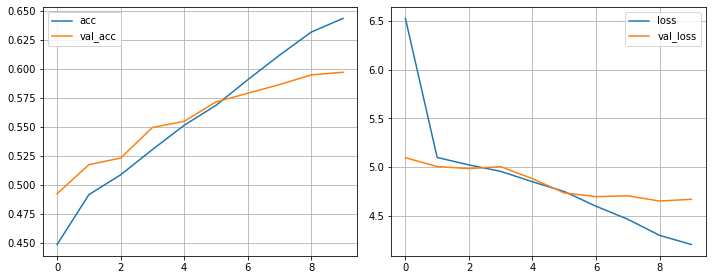

In [31]:
manager.plot_history()

# **Inference**

In [32]:
latest_ckpt_path = manager.latest_checkpoint()
if latest_ckpt_path is not None:
    manager.make_clean()

Restored checkpoint: assets/20210625-154612/ckpt/cp-009-4.6517.pt
Checkpoint folder assets/20210625-154612/ckpt is clean, 9310.53MB free.


In [33]:
latest_ckpt = manager.load_latest_checkpoint(latest_ckpt_path)

model.load_state_dict(latest_ckpt["model_state_dict"])

<All keys matched successfully>

In [34]:
pred_1st = trainer.test_epoch(ts_dataloader)

Test: 100%|██████████| 38/38 [00:16<00:00,  2.37it/s]


In [35]:
pred_1st[:3]

[[1, 5, 2], [9, 7, 0], [13, 10, 6]]

# **Submission**

In [36]:
sample_submission_path = HPARAMS.data_path / Path("sample_submission.json")
sample_submission = pd.read_json(sample_submission_path, orient = "records", encoding = "utf-8-sig")

submission_df = sample_submission.copy()
submission_df

,ID,summary_index1,summary_index2,summary_index3
0,79095,0,1,2
1,204506,0,1,2
2,142079,0,1,2
3,110816,0,1,2
4,207249,0,1,2
...,...,...,...,...
2999,211427,0,1,2
3000,113879,0,1,2
3001,207079,0,1,2
3002,161740,0,1,2


In [37]:
submission_df.iloc[:, 1:] = np.array(pred_1st)
submission_df

,ID,summary_index1,summary_index2,summary_index3
0,79095,1,5,2
1,204506,9,7,0
2,142079,13,10,6
3,110816,0,9,8
4,207249,4,1,3
...,...,...,...,...
2999,211427,12,1,10
3000,113879,0,5,3
3001,207079,2,1,4
3002,161740,8,0,6


In [38]:
submission_json = []
for value in tqdm(submission_df.values):
    answer = OrderedDict({"ID": str(value[0])})
    answer.update({f"summary_index{i+1}": str(v) for i, v in enumerate(value[1:])})
    
    submission_json.append(answer)

100%|██████████| 3004/3004 [00:00<00:00, 85481.31it/s]


In [39]:
submission_json[:3]

[OrderedDict([('ID', '79095'),
              ('summary_index1', '1'),
              ('summary_index2', '5'),
              ('summary_index3', '2')]),
 OrderedDict([('ID', '204506'),
              ('summary_index1', '9'),
              ('summary_index2', '7'),
              ('summary_index3', '0')]),
 OrderedDict([('ID', '142079'),
              ('summary_index1', '13'),
              ('summary_index2', '10'),
              ('summary_index3', '6')])]

In [40]:
save_path = HPARAMS.cwd / Path("assets", HPARAMS.model_name, f"submission-{HPARAMS.model_name}.json")
save_path.parent.mkdir(parents = True, exist_ok = True)

try:
    with open(save_path, "w") as f:
        json.dump(submission_json, f, indent = 4, sort_keys = False)
    message = f"Json saved {save_path}"
except Exception as e:
    message = f"Failed to save: {e}"

print(message)

Json saved /home/ubuntu/tmp_git/nipa-2021/assets/20210625-154612/submission-20210625-154612.json


In [ ]:
# try:
#     from google.colab import files
#     files.download(save_path)
# except:
#     pass